In [2747]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

from sklearn import (linear_model, metrics, neural_network, pipeline, preprocessing, model_selection)

In [2791]:
"""
Load data.
Change path variable to your location of CSV files.
"""

path = "./data/"

df_zones = pd.read_csv(path + "zona_censal_comuna.csv")
df_demos = pd.read_csv(path + "age_demo_comunas.csv")
df_qua = pd.read_csv(path + "matrix_cuarentena_comunas_semanas.csv")
df_inf = pd.read_csv(path + "dp1_contagiados_por_comuna.csv")
df_mob1 = pd.read_csv(path + "od_zones_weeks_20200301.enc.csv")
df_mob2 = pd.read_csv(path + "od_zones_weeks_20200401.enc.csv")
df_mob = pd.concat([df_mob1, df_mob2])

In [2792]:
normalize = False
# normalize = True
log_trick = False
# log_trick = True
differences = False
# differences = True

In [2793]:
if differences:
    mob_t = 5
    epid_t = 4
    T_d = 4
else:
    mob_t = 4
    epid_t = 5
    T_d = 5

### Census zones & Communes

In [2794]:
"""
Census zone information (only for Santiago).

Relevant columns:
    GEOCODIGO = census zone id
    COMUNA    = commune id
"""
df_zones

,OBJECTID,REGION,PROVINCIA,NOM_COMUNA,COMUNA,GEOCODIGO
0,1,13,134,PAINE,13404,13404011003
1,2,13,134,PAINE,13404,13404011002
2,3,13,134,PAINE,13404,13404061004
3,4,13,134,PAINE,13404,13404061001
4,5,13,134,PAINE,13404,13404061002
...,...,...,...,...,...,...
1860,1861,13,136,EL MONTE,13602,13602031001
1861,1862,13,136,TALAGANTE,13601,13601021001
1862,1863,13,136,TALAGANTE,13601,13601021002
1863,1864,13,135,ALHUÉ,13502,13502011001


In [2795]:
"""
Create dictionaries for (standardized) ID lookups of zones and communes.
"""
# Enumerate communes with standardized IDs (from 0 to 50)
df_coms = df_zones[["COMUNA","NOM_COMUNA"]].drop_duplicates()
dict_com_sid_com_info = {com_sid:com_info for com_sid, com_info in enumerate(zip(df_coms.COMUNA, df_coms.NOM_COMUNA))}
dict_com_id_com_sid = {com_id:com_sid for com_sid, com_id in enumerate(df_coms.COMUNA)}
dict_com_name_com_sid = {com_name:com_sid for com_sid, com_name in enumerate(df_coms.NOM_COMUNA)}

# Dictionary mapping census zone id to its commune standardized id
dict_zone_id_com_sid = {zone_id:dict_com_id_com_sid[com_id] for zone_id, com_id in zip(df_zones.GEOCODIGO, df_zones.COMUNA)}

# Dictionary mapping commune sID to population
get_com_sid = lambda i: dict_com_id_com_sid[i] if i in dict_com_id_com_sid else pd.NaT
df_pop = df_demos[["COMUNA","T_POB"]]
df_pop.loc[:,"COMUNA"] = df_pop.loc[:,"COMUNA"].apply(get_com_sid)
df_pop = df_pop.dropna()
dict_com_sid_pop = {sid:pop for sid, pop in zip(df_pop.COMUNA, df_pop.T_POB)}

/Users/gael/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Mobility data

In [2796]:
"""
Logs of averaged amount of movement of individuals across census zones.

Relevant columns:
    mean_population_zone = weekly mean of daily number of individuals
                                that spend majority of their day in census zone [code_zone]
                                that live in census zone [home_zone]
    code_zone            = visiting census zone
    home_zone            = home census zone
    week                 = week of year
    time_block           = T1 - 10:00-13:00, T2 - 14:00-17:00
"""
df_mob

,mean_population_zone,code_zone,week,time_block,home_zone
0,154.800000,13124061022,9,T1,13124061005
1,14.200000,13101081001,9,T1,13126031003
2,12.800000,13123021005,9,T1,13120041002
3,26.800000,13114021002,9,T1,13114061001
4,44.200000,13114131005,9,T1,13114031002
...,...,...,...,...,...
4642958,1.666667,13130031001,17,T2,13112051010
4642959,1.666667,13119011005,17,T2,13106051001
4642960,1.666667,13301011001,17,T1,13104051001
4642961,1.666667,13119201001,17,T2,13124061005


In [2797]:
"""
Create dataframe of edge information: (home zone, visiting zone, week, mean population)
Aggregate information into communes.
"""
t = df_mob.week.min()    # earliest week available
get_zone_com_sid = lambda i: dict_zone_id_com_sid[i]

# Get normalization constants per commune per week according to mobility data
df_normals = df_mob.copy()
df_normals.columns = ['mean_pop','travel_id','week','time_block','home_id']
df_normals.loc[:,"home_id"] = df_normals.loc[:,"home_id"].apply(get_zone_com_sid)
df_normals.loc[:,"travel_id"] = df_normals.loc[:,"travel_id"].apply(get_zone_com_sid)
df_normals.loc[:,"week"] = df_normals.loc[:,"week"] - t    # zero index weeks                
df_normals = df_normals.groupby(['week','home_id','time_block']).agg({'mean_pop':'sum'}).reset_index()
df_normals = df_normals.groupby(['week','home_id']).agg({'mean_pop':'mean'}).reset_index()

# Remove intra-zone mobility, Aggregate mean population of same edges in same week
df_edge_list = df_mob.copy()
df_edge_list.columns = ['mean_pop','travel_id','week','time_block','home_id']
df_edge_list = df_edge_list[df_edge_list["home_id"] != df_edge_list["travel_id"]]    # remove intra-zone info
df_edge_list.loc[:,"home_id"] = df_edge_list.loc[:,"home_id"].apply(get_zone_com_sid)
df_edge_list.loc[:,"travel_id"] = df_edge_list.loc[:,"travel_id"].apply(get_zone_com_sid)
df_edge_list.loc[:,"week"] = df_edge_list.loc[:,"week"] - t                               
df_edge_list = df_edge_list.groupby(['home_id','travel_id','week']).agg({'mean_pop':'sum'}).reset_index()

# Get number of people that stayed in home zone, averaged over time blocks
df_intra = df_mob.copy()
df_intra.columns = ['mean_pop','travel_id','week','time_block','home_id']
df_intra = df_intra[df_intra["home_id"] == df_intra["travel_id"]]    # get intra-zone info
df_intra.loc[:,"home_id"] = df_intra.loc[:,"home_id"].apply(get_zone_com_sid)
df_intra.loc[:,"travel_id"] = df_intra.loc[:,"travel_id"].apply(get_zone_com_sid)
df_intra.loc[:,"week"] = df_intra.loc[:,"week"] - t
df_intra = df_intra.groupby(['week','home_id','time_block']).agg({'mean_pop':'sum'}).reset_index()
df_intra = df_intra.groupby(['week','home_id']).agg({'mean_pop':'mean'}).reset_index()
df_intra = df_intra.pivot_table('mean_pop', ['home_id'], 'week')

In [2798]:
df_intra

week,0,1,2,3,4,5,6,7,8
home_id,,,,,,,,,
0,2023.400000,1974.100000,2514.300000,2712.500000,5731.666667,3158.066667,2953.216667,2972.400000,2971.875000
1,6834.308333,6879.900000,9145.725000,10151.500000,20788.750000,11128.475000,10596.450000,10705.675000,10507.208333
2,15531.125000,15291.583333,20651.575000,23630.225000,48146.666667,24469.441667,22681.558333,22917.350000,22688.500000
3,7573.466667,7328.383333,11053.400000,12443.025000,25608.500000,12723.500000,11869.758333,12096.250000,11929.416667
4,51.800000,53.800000,29.300000,54.600000,123.250000,65.400000,59.400000,57.900000,59.750000
5,5768.333333,5857.541667,7962.866667,8862.375000,18594.333333,9555.900000,8967.975000,9227.375000,9213.750000
6,13.200000,11.200000,11.600000,11.500000,20.916667,8.500000,8.800000,8.700000,7.875000
7,82.300000,81.725000,92.000000,105.800000,218.833333,122.733333,115.100000,122.300000,124.750000
8,15173.641667,15319.916667,18827.433333,20904.458333,42013.583333,21406.825000,20432.325000,20081.125000,20846.500000


In [2799]:
# Create features of intra-zone mobility (or lack of)
s = df_intra.to_numpy()

In [2800]:
"""
Create mobility matrix: A[i,j,t] 
Get normalization constants: normals[i,t]
"""
T = df_mob.week.max() - df_mob.week.min() + 1
N = len(dict_com_sid_com_info)

A = np.zeros((N, N, T))
edge_list = zip(df_edge_list.home_id, df_edge_list.travel_id, df_edge_list.week, df_edge_list.mean_pop)
for edge in edge_list:
    i, j, t, a_ijt = edge
    A[i,j,t] += a_ijt
    
normals = np.zeros((N,T))
normal_list = zip(df_normals.home_id, df_normals.week, df_normals.mean_pop)
for norm in normal_list:
    i, t, z_it = norm
    normals[i,t] = z_it

    
# normalize entries
if normalize:
#     get_com_sid = lambda i: dict_com_id_com_sid[i] if i in dict_com_id_com_sid else pd.NaT
#     df_pop = df_demos[["COMUNA","T_POB"]]
#     df_pop["COMUNA"] = df_pop.loc[:,"COMUNA"].apply(get_com_sid)
#     df_pop = df_pop.dropna()
#     dict_com_sid_pop = {sid:pop for sid, pop in zip(df_pop.COMUNA, df_pop.T_POB)}

#     for j in range(N):
#         A[:,j,:] = A[:,j,:] / dict_com_sid_pop[j]
    
    for t in range(T):
        A[:,:,t] = A[:,:,t] / normals[:,t][:,None]

In [2801]:
# Mobility matrix over 51 communes in Santiago over 9 time periods (weeks 9-17).
print(A.shape)

# Matrix is not sparse
print(np.count_nonzero(A), N*N*T)

(51, 51, 9)
21931 23409


### Infections data

In [2802]:
"""
Logs of cumulative number of infections in each commune in Chile over differently spaced out days in weeks 14-19.

Relevant columns:
    Codigo comuna          = commune ID
    Date (e.g. 2020-03-30) = number of confirmed cases of COVID19 on that day.
"""
df_inf

,Unnamed: 0,Region,Codigo region,Comuna,Codigo comuna,Poblacion,2020-03-30,2020-04-01,2020-04-03,2020-04-06,...,2020-04-15,2020-04-17,2020-04-20,2020-04-24,2020-04-27,2020-05-01,2020-05-04,2020-05-08,2020-05-11,Tasa
0,0,Arica y Parinacota,15,Arica,15101,247552.0,6.0,6.0,12.0,41.0,...,124.0,134.0,166.0,224.0,270.0,297.0,310.0,328.0,353.0,142.6
1,1,Arica y Parinacota,15,Camarones,15102,1233.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Arica y Parinacota,15,General Lagos,15202,810.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Arica y Parinacota,15,Putre,15201,2515.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Tarapacá,1,Alto Hospicio,1107,129999.0,0.0,0.0,0.0,5.0,...,15.0,16.0,27.0,39.0,55.0,77.0,128.0,161.0,188.0,144.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,341,Magallanes,12,Punta Arenas,12101,141984.0,29.0,87.0,143.0,203.0,...,416.0,470.0,516.0,581.0,623.0,685.0,744.0,825.0,858.0,604.3
342,342,Magallanes,12,Rio Verde,12103,211.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
343,343,Magallanes,12,San Gregorio,12104,681.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,146.8
344,344,Magallanes,12,Timaukel,12303,282.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2803]:
"""
Aggregate infections data into weeks.
Only keep data for communes in Santiago.
"""
get_com_sid = lambda i: dict_com_id_com_sid[i] if i in dict_com_id_com_sid else pd.NaT
df_y = pd.DataFrame()
df_y["com"] = df_inf["Codigo comuna"]
df_y.loc[:,"com"] = df_y.loc[:,"com"].apply(get_com_sid)
# df_y["week14"] = df_inf["2020-03-30"] + df_inf["2020-04-01"] + df_inf["2020-04-03"]
# df_y["week15"] = df_inf["2020-04-06"] + df_inf["2020-04-08"] + df_inf["2020-04-10"]
# df_y["week16"] = df_inf["2020-04-13"] + df_inf["2020-04-15"] + df_inf["2020-04-17"]
# df_y["week17"] = df_inf["2020-04-20"] + df_inf["2020-04-24"]
# df_y["week18"] = df_inf["2020-04-27"] + df_inf["2020-05-01"]
# df_y["week19"] = df_inf["2020-05-04"] + df_inf["2020-05-08"]
df_y["week13"] = df_inf["2020-03-30"]
df_y["week14"] = df_inf["2020-04-06"]
df_y["week15"] = df_inf["2020-04-13"]
df_y["week16"] = df_inf["2020-04-20"]
df_y["week17"] = df_inf["2020-04-27"]
df_y["week18"] = df_inf["2020-05-04"]
df_y["week19"] = df_inf["2020-05-11"]
df_y = df_y.dropna().sort_values("com")

# Get time-evolving cumulative infections vector
y = df_y.drop("com",1).to_numpy()

# Normalize according to commune population
if normalize:
    for j in range(N):
        y[j,:] = y[j,:] / dict_com_sid_pop[j]

# Transform data to ensure positivity in regression
if log_trick:
    y = np.log(y + 1)
    
# Get differences
if differences:
    y_prev = y[:,:-1]
    y = y[:,1:] - y_prev

In [2804]:
# Cumulative infections over 51 communes in Santiago over 6 time periods (weeks 14-19)
y.shape

(51, 7)

### Quarantine data

In [2805]:
"""
Logs of percentage of quarantine measures in communes in Santiago.
"""
get_com_sid_from_name = lambda i: dict_com_name_com_sid[i.upper()] if i.upper() in dict_com_name_com_sid else pd.NaT
df_q = df_qua.copy()
df_q["comuna"] = df_qua.loc[:,"comuna"].apply(get_com_sid_from_name)
df_q.dropna().sort_values("comuna")

q = df_q.drop("comuna",1).to_numpy()

In [2806]:
# B = A[:,:,mob_t:]
# d = q[:,:epid_t]
# cp = com_pop[:,mob_t:]

# r = 4
# # at = np.diag(B[:,:,r])
# at = np.dot(B[:,:,r],np.ones(N))
# dt = d[:,r]

# fig, ax = plt.subplots(figsize=(10,10))
# ax.scatter(dt, at)
# for i in range(dt.shape[0]):
#     if com_pop[i,t] > 0:
#         name = dict_com_sid_com_info[i][1]
#         point = [dt[i],at[i]]
#         ax.text(dt[i], at[i], name)
# ax.set_title('Quarantine vs. Mobility', size = 20)
# ax.set_xlabel('Quarantine percentage q_t', size = 15)
# ax.set_ylabel('Movement of people from commune: \sum_j a_ijt', size = 15)
# plt.show()

### Demographics

In [2807]:
"""
Demographics information for all communes in Chile.
"""
df_demos.head()

,COMUNA,NOM_COMUNA,Densidad_,SUPERFICIE__KM2_,T_POB,T_HOM,T_MUJ,T_VIV,por_muj,por_hom,...,55 a 59,60 a 64,65 a 69,70 a 74,75 a 79,80 a 84,85 a 89,90 a 94,95 a 99,100 o más
0,13101,SANTIAGO,17483.935547,23.135237,404495,206678,197817,193628,0.489047,0.510953,...,16473,12820,9465,7449,5328,3738,2602,1027,302,108
1,13102,CERRILLOS,4817.263672,16.779650,80832,39631,41201,24547,0.509712,0.490288,...,4510,3602,2963,2550,1862,1154,738,267,57,18
2,13103,CERRO NAVIA,11950.771484,11.097359,132622,65438,67184,38020,0.506583,0.493417,...,7466,6013,5340,4550,3160,1842,1028,340,103,34
3,13104,CONCHALÍ,11427.335938,11.109763,126955,61877,65078,37759,0.512607,0.487393,...,7941,5988,4801,4250,3533,2521,1625,552,127,43
4,13105,EL BOSQUE,11344.626953,14.324402,162505,79372,83133,47941,0.511572,0.488428,...,10091,8212,6348,5352,3737,2362,1473,452,104,42


In [2808]:
"""
Get demographic information for communes in Santiago.
"""
df_C = df_demos.copy()
df_C.loc[:,"COMUNA"] = df_C.loc[:,"COMUNA"].apply(get_com_sid)
df_C = df_C.dropna().sort_values("COMUNA")
df_C.drop(["COMUNA", "NOM_COMUNA", "NOM_COMUNA.1"], axis=1, inplace=True)

# Get demographics feature matrix
C = df_C.to_numpy()

In [2809]:
# Demographics features over 51 communes in Santiago
print(C.shape)

(51, 31)


### Feature Extraction

In [2811]:
# Feature extraction
def extract_features(A, tf, y, params):
    """
    Extracts feature vectors for each sequential input.
    Returns a matrix of all features X[N,L,T] where X[:,:,t] is matrix of features for data at time t.
    """
    
    # get overlap of mobility data and infections data - hardcoded
    A = A[:,:,mob_t:]
    y = y[:,:epid_t]
    
    diff = params[6]
    if diff:
        q, s, y_prev = tf
        y_prev[:,epid_t]
    else:
        q, s = tf
    q = q[:,:epid_t]
    s = s[:,mob_t:]
    
    X = np.zeros((N, L, T))
    for t in range(T):
        At = A[:,:,t]
        yt = y[:,t]
        qt = q[:,t]
        st = s[:,t]
        
        x1 = np.diag(At)
        x2 = np.dot(At.T, np.ones(N))
        x3 = np.dot(At, np.ones(N))
        x4 = yt
        x5 = np.dot(At.T, yt)
        x6 = np.dot(At, yt)
        x7 = qt
        x8 = st
#         x9 = y_prev[:,t]

        Xt = np.stack((x1,x2,x3,x4,x5,x6,x7,x8), axis=-1)
        X[:,:,t] = Xt
    
#         x1 = yt
#         x2 = y_prev[:,t]
# # # #         x3 = qt
# # # # #         x2 = np.ones(N)*(t+1)
# #         Xt = np.stack((x1), axis=-1).reshape((N,1))
#         Xt = np.stack((x1,x2), axis=-1)
#         X[:,:,t] = Xt
    
        
    return X, y

def collect_data(X, y, C, params):
    """
    Collects data into a big 'ol matrix and output matrix to feed into a regression method.
    """
    N, T, L, K, k, add_demos = params[:6]

    if add_demos:
        c = C.shape[1]
    else:
        c = 0
                  
    Z = np.zeros((N*(T-K), L*(K-k)+c))
    for t in range(T-K):
        Zt = X[:,:,t:t+K-k].transpose([0,2,1]).reshape((N, L*(K-k)))
        if add_demos:
            Zt = np.column_stack((Zt, C))
        Z[N*t:N*(t+1),:] = Zt
                 
    Y = np.zeros(N*(T-K))
    for t in range(T-K):
        Y[N*t:N*(t+1)] = y[:,t+K].reshape((N))
        
    return Z, Y

def timeseries_train_test_split(X, y, params):
    """
    Splits data into a train and test data.
    """
    N, T, L, K, k = params[:5]
    n = 1                        # number of test points
    
    X_train = X[:N*(T-K-n),:]
    X_test = X[N*(T-K-n):,:]
    y_train = y[:N*(T-K-n)]
    y_test = y[N*(T-K-n):]
    
    return X_train, y_train, X_test, y_test

In [2820]:
"""
Extract features
"""
N = 51                       # num communes
T = T_d                        # num total data points

L = 8                        # num features added
K = 2                        # num lags
k = 0                        # num skips
# add_demos = False             # add demographic features
add_demos = True             # add demographic features
params = [N,T,L,K,k,add_demos,differences]

if differences:
    time_features = [q, s, y_prev]
else:
    time_features = [q, s]
F, y = extract_features(A, time_features, y, params)
X_data, y_data = collect_data(F, y, C, params)
X_train, y_train, X_test, y_test = timeseries_train_test_split(X_data, y_data, params)
print(F.shape, X_data.shape, y_data.shape)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(51, 8, 5) (153, 47) (153,)
(102, 47) (102,) (51, 47) (51,)


In [2821]:
# print(F)
# print(X_data, y_data)
# print(X_train)
# print(y_train)
# print(X_test)
# print(y_test)
# print(y_test.mean())

### Linear Regression

3.60e+01
-1.544959533110298e+16 [ 6.44596171e-04  1.22457154e-04  1.23286682e-04 -2.02693319e-01
 -2.99300831e-06  5.99306310e-06 -7.38933361e+00 -3.58920523e-04
 -8.19253799e-04 -6.51885268e-05  9.61177790e-04  1.48915514e+00
 -2.78117768e-07 -1.07015962e-07  1.90385945e+01 -2.65875769e-03
 -4.83518369e-03  2.24549325e-03 -3.87851251e+07  8.52660062e+06
  8.52660063e+06 -2.31464169e-04  1.54495953e+16  1.54495953e+16
  1.85202356e+00  1.75824871e-02  3.02585245e+07  3.02585245e+07
  3.02585245e+07  3.02585245e+07  3.02585245e+07  3.02585245e+07
  3.02585245e+07  3.02585245e+07  3.02585245e+07  3.02585245e+07
  3.02585245e+07  3.02585245e+07  3.02585245e+07  3.02585245e+07
  3.02585245e+07  3.02585245e+07  3.02585245e+07  3.02585244e+07
  3.02585245e+07  3.02585246e+07  3.02585246e+07]
0.9458765348160418
153.31372549019608


/Users/gael/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


Text(0, 0.5, 'Commune')

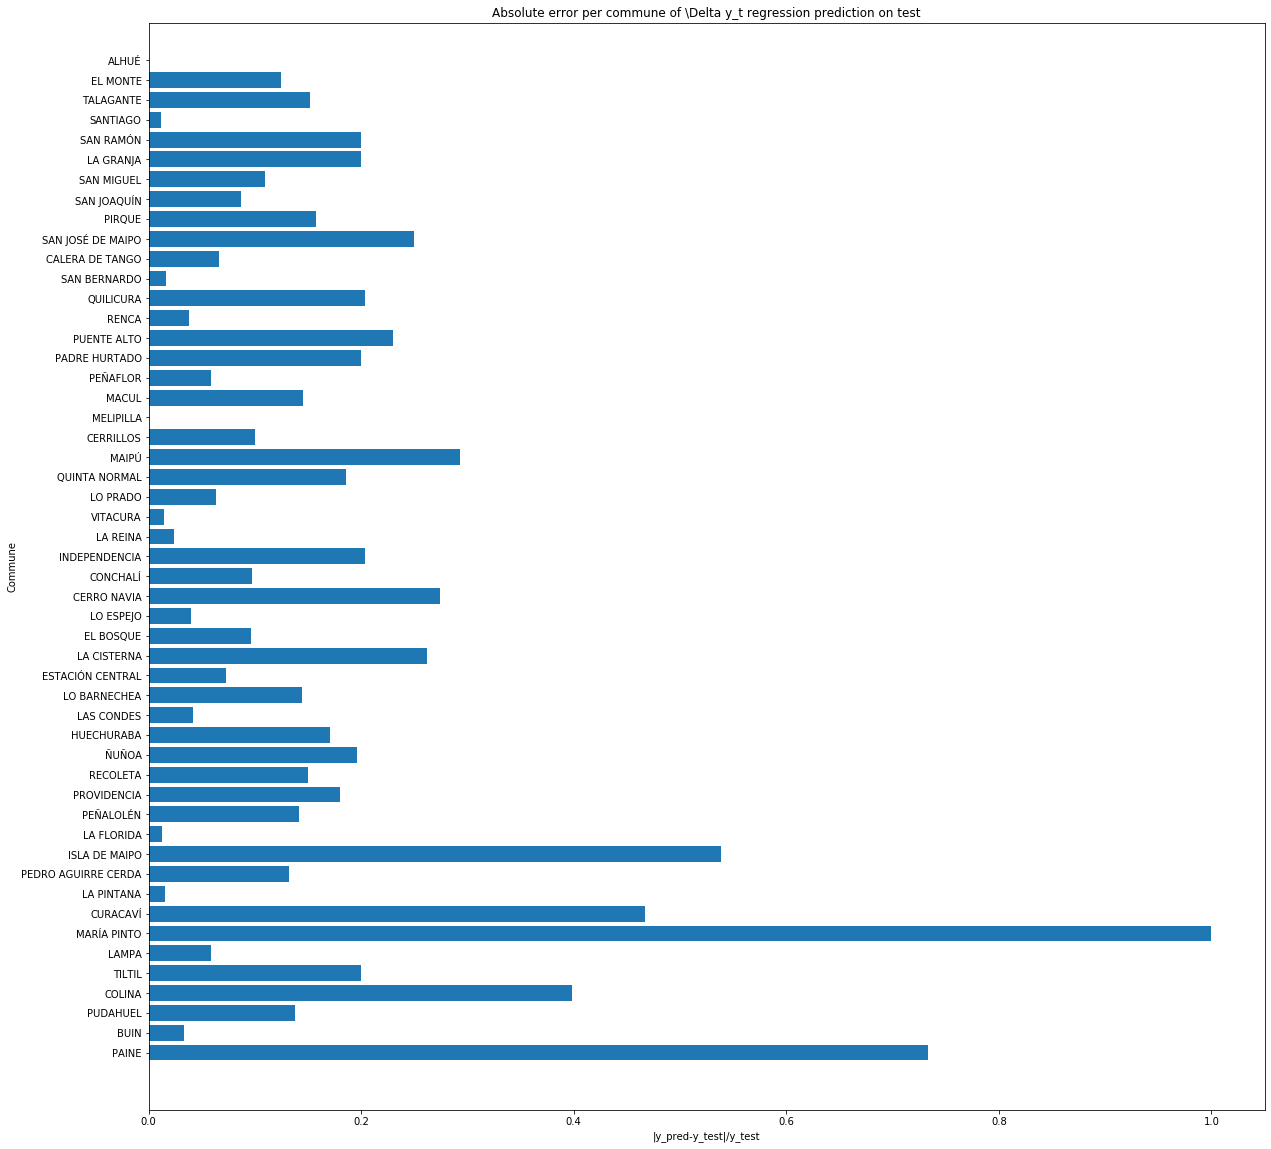

In [2822]:
reg = linear_model.LinearRegression(normalize=True)
reg.fit(X_train, y_train)
reg_rmse = np.sqrt(metrics.mean_squared_error(y_test, reg.predict(X_test)))

print("{:.2e}".format(reg_rmse))
print(reg.intercept_, reg.coef_)
print(reg.score(X_test, y_test))
print(y_test.mean())
er = np.abs(y_test - reg.predict(X_test))
a = []
b = []
for i in range(N):
    a.append(dict_com_sid_com_info[i][1])
    b.append(er[i]/y_test[i])
plt.subplots(figsize=(20, 20))
plt.barh(a,b)
plt.title('Absolute error per commune of \Delta y_t regression prediction on test')
plt.xlabel('|y_pred-y_test|/y_test')
plt.ylabel('Commune')

In [2823]:
y_pred = reg.predict(X_test)
print(y_pred - y_test)
# for i in range(len(y_test)):
#     commune_id = dict_com_sid_com_info[i]
#     yi_act = y_test[i]
#     yi_pred = y_pred[i]
#     info_i = (commune_id, yi_act, yi_pred)
#     print(info_i)

[ 11.  -2.  23.  41.   1.   4.   1.   7.   3.  17.   7.   4.  36.  36.
 -34.  57.  14.  15.  28. -15.  22.  17.   4.  37.  11. -50.   2.   2.
  -7.  36. 117.   8.   0. -16.  -3.   8. 176.   5. -48.  -6.   1.  -2.
   3.  13.  19.  19. -18.   8.   5.  -2.   0.]


### LASSO

In [2824]:
lasso = linear_model.LassoCV(cv=model_selection.TimeSeriesSplit(n_splits=5), alphas=None, tol = 10000, normalize=True) 
lasso.fit(X_train, y_train)
optimal_alpha = lasso.alpha_
lasso2 = linear_model.Lasso(alpha=optimal_alpha, normalize=True)
lasso2.fit(X_train, y_train)
lasso2_rmse = np.sqrt(metrics.mean_squared_error(y_test, lasso2.predict(X_test)))

print("{:e}".format(lasso2_rmse))

2.474581e+01


In [2825]:
print("{:.2e}".format(reg_rmse) + ' / ' + "{:.2e}".format(lasso2_rmse))
print("{:.2e}".format(y_test.mean()))

3.60e+01 / 2.47e+01
1.53e+02


In [2819]:
# Feature selection
fnames = []
for i in range(1,X_data.shape[1]+1):
    if 1 <= i <= L:
        fnames.append('x'+str(i)+'_2')
    elif L+1 <= i <= 2*L:
        fnames.append('x'+str(i-L)+'_1')
    else:
        fnames.append('c'+str(i-2*L))

print(lasso2.coef_)
print(lasso2.intercept_)
for pair in zip(fnames, lasso2.coef_):
    print(pair)

[ 5.74504586e-04 -0.00000000e+00  4.61289084e-04 -5.01877962e-01
 -2.60290939e-06 -0.00000000e+00 -2.34296972e+00 -5.83529594e-04
 -3.55691188e-04 -1.03547753e-04 -0.00000000e+00  1.75742574e+00
  0.00000000e+00  9.15782919e-07  0.00000000e+00 -3.89562725e-04]
1.6230092182744755
('x1_2', 0.0005745045855897367)
('x2_2', -0.0)
('x3_2', 0.0004612890839426731)
('x4_2', -0.5018779624222051)
('x5_2', -2.6029093934923923e-06)
('x6_2', -0.0)
('x7_2', -2.3429697199880835)
('x8_2', -0.0005835295941184168)
('x1_1', -0.00035569118774555575)
('x2_1', -0.00010354775287643717)
('x3_1', -0.0)
('x4_1', 1.757425736636948)
('x5_1', 0.0)
('x6_1', 9.157829192337736e-07)
('x7_1', 0.0)
('x8_1', -0.0003895627253508902)


###### The following implementations are not finished yet...

### XGBoost

In [ ]:
X_train, y_train, X_test, y_test = timeseries_train_test_split(X=X, y=y)


scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

train_test_plot(model=xgb, X_train=X_train_scaled, X_test=X_test_scaled)


### Neural Network

In [ ]:
X_train, y_train, X_test, y_test = timeseries_train_test_split(X=X, y=y)

reg = neural_network.MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
reg.fit(X, y)

train_test_plot(model=reg, X_train=X_train_scaled, X_test=X_test_scaled)